<a href="https://colab.research.google.com/github/amelft81/ASDEEG/blob/main/EEGSampleGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating 1000 synthetic EEG images...
  Generated 100/1000 samples...
  Generated 200/1000 samples...
  Generated 300/1000 samples...
  Generated 400/1000 samples...
  Generated 500/1000 samples...
  Generated 600/1000 samples...
  Generated 700/1000 samples...
  Generated 800/1000 samples...
  Generated 900/1000 samples...
  Generated 1000/1000 samples...
Dataset generation complete.

--- Dataset Summary ---
Total samples: 1000
Image shape: (224, 224, 3)
Class distribution: Counter({np.int64(0): 828, np.int64(1): 172})

Applying RandomOverSampler to balance the dataset...
Original dataset shape: Counter({np.int64(0): 828, np.int64(1): 172})
Resampled dataset shape: Counter({np.int64(0): 828, np.int64(1): 828})
Oversampling complete.

--- Resampled Dataset Summary ---
Total resampled samples: 1656
Resampled image shape: (224, 224, 3)
Resampled class distribution: Counter({np.int64(0): 828, np.int64(1): 828})

Displaying a few generated EEG images...


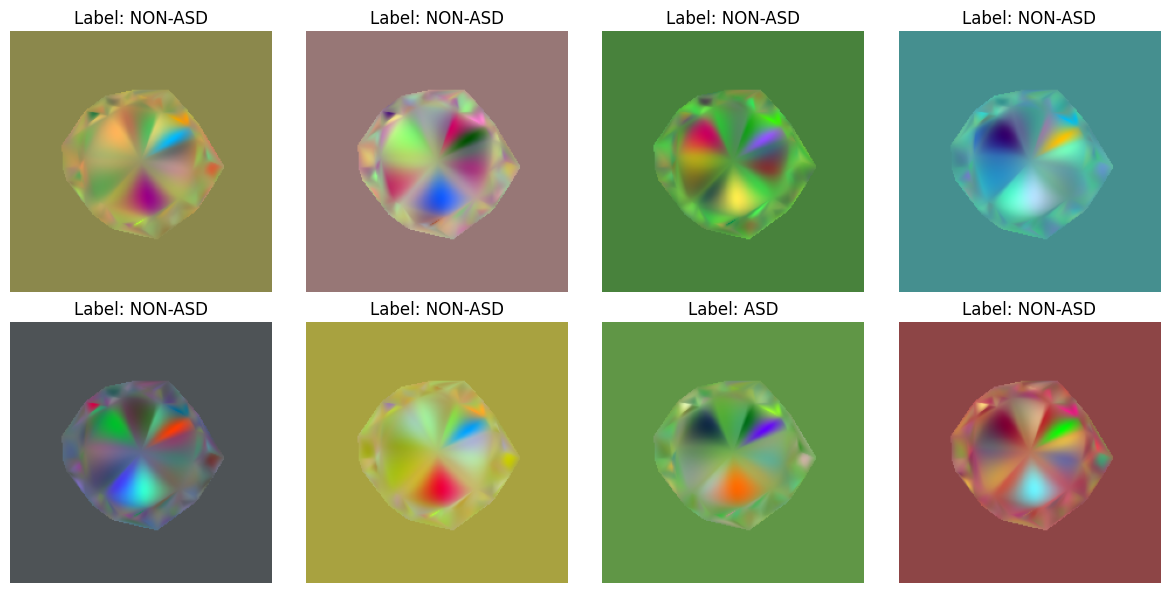


Resampled dataset saved to 'synthetic_eeg_dataset' directory.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import os

# --- Configuration Parameters (based on paper and common EEG practices) ---
NUM_ELECTRODES = 116 # Paper mentions 116 electrodes after exclusion
SAMPLING_RATE = 500  # Hz, as per paper
SEGMENT_LENGTH_SEC = 1 # seconds, as per paper
NUM_SAMPLES_PER_SEGMENT = SAMPLING_RATE * SEGMENT_LENGTH_SEC # 500 samples
IMAGE_SIZE = 224     # 224x224 pixels, as per ResNet-50 input
FREQ_BANDS = {
    'theta': (4, 7),   # Hz
    'alpha': (8, 13),  # Hz
    'beta': (13, 30)   # Hz
}
# Desired class distribution (approximate from paper: 81% NON-ASD, 19% ASD)
ASD_RATIO = 0.19
NON_ASD_RATIO = 1 - ASD_RATIO

# --- 1. Simulate Electrode Positions (Simplified Azimuthal Equidistant Projection) ---
# We'll simulate electrode positions on a 2D plane as if they've already been projected.
# A simple circular arrangement or random points within a circle can represent this.
def generate_electrode_positions(num_electrodes, radius=0.5):
    """Generates simulated 2D electrode positions in a circular pattern."""
    angles = np.linspace(0, 2 * np.pi, num_electrodes, endpoint=False)
    x = radius * np.cos(angles) + np.random.normal(0, 0.05, num_electrodes) # Add some noise
    y = radius * np.sin(angles) + np.random.normal(0, 0.05, num_electrodes) # Add some noise
    # Add a central electrode
    x = np.append(x, 0)
    y = np.append(y, 0)
    return np.array([x, y]).T

# --- 2. Simulate Raw EEG Signals ---
def generate_eeg_signal(num_samples, sampling_rate, freq_bands, is_asd=False):
    """
    Generates a simulated EEG signal for one electrode.
    ASD signals might have slightly different characteristics (e.g., more noise or altered band power).
    """
    t = np.linspace(0, num_samples / sampling_rate, num_samples, endpoint=False)
    signal = np.zeros(num_samples)

    # Add base frequencies for each band
    for band_name, (low_f, high_f) in freq_bands.items():
        center_f = (low_f + high_f) / 2
        amplitude = np.random.uniform(0.5, 1.5)
        # ASD signals might have altered power in certain bands (simplified simulation)
        if is_asd:
            if band_name == 'theta': # Example: slightly higher theta in ASD
                amplitude *= 1.2
            elif band_name == 'beta': # Example: slightly lower beta in ASD
                amplitude *= 0.8
        signal += amplitude * np.sin(2 * np.pi * center_f * t + np.random.uniform(0, 2 * np.pi))

    # Add random noise
    noise_level = np.random.uniform(0.1, 0.5)
    if is_asd: # ASD signals might be noisier (simplified simulation)
        noise_level *= 1.2
    signal += noise_level * np.random.randn(num_samples)

    return signal

# --- 3. Apply FFT and Extract Frequency Band Power ---
def get_band_power(signal, sampling_rate, freq_range):
    """Calculates the average power in a specific frequency range using FFT."""
    n = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(n, 1 / sampling_rate)

    # Find indices corresponding to the frequency range
    min_freq, max_freq = freq_range
    indices = np.where((xf >= min_freq) & (xf <= max_freq))

    # Calculate power (magnitude squared) in the specified band
    power = np.mean(np.abs(yf[indices])**2)
    return power

# --- 4. Interpolate to a Grid and Create RGB Image ---
def create_eeg_image(electrode_positions, band_powers, image_size):
    """
    Interpolates band powers onto a 2D grid and creates an RGB image.
    Each channel (R, G, B) corresponds to a frequency band.
    """
    grid_x, grid_y = np.mgrid[-1:1:complex(0, image_size), -1:1:complex(0, image_size)]

    # Interpolate for each band
    interp_theta = griddata(electrode_positions, band_powers['theta'], (grid_x, grid_y), method='cubic', fill_value=0)
    interp_alpha = griddata(electrode_positions, band_powers['alpha'], (grid_x, grid_y), method='cubic', fill_value=0)
    interp_beta = griddata(electrode_positions, band_powers['beta'], (grid_x, grid_y), method='cubic', fill_value=0)

    # Normalize each interpolated band to 0-255 for image representation
    # Handle cases where min/max might be the same (flat array)
    def normalize_band(arr):
        min_val = np.min(arr)
        max_val = np.max(arr)
        if max_val == min_val:
            return np.zeros_like(arr) # Or some default grey
        return ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # The paper mentions Theta, Alpha, Beta corresponding to RGB, but doesn't specify order.
    # Let's assign them: Theta -> Red, Alpha -> Green, Beta -> Blue
    img_r = normalize_band(interp_theta)
    img_g = normalize_band(interp_alpha)
    img_b = normalize_band(interp_beta)

    # Stack into an RGB image
    eeg_image = np.stack([img_r, img_g, img_b], axis=-1)
    return eeg_image

# --- Main Dataset Generation Function ---
def generate_synthetic_eeg_dataset(num_samples_total, asd_ratio, image_size, num_electrodes, sampling_rate, freq_bands):
    """
    Generates a synthetic dataset of EEG images.
    Returns a list of (image, label) tuples.
    """
    dataset = []
    electrode_positions = generate_electrode_positions(num_electrodes)

    print(f"Generating {num_samples_total} synthetic EEG images...")
    for i in range(num_samples_total):
        # Determine label based on desired ratio
        is_asd = np.random.rand() < asd_ratio
        label = 1 if is_asd else 0 # 1 for ASD, 0 for NON-ASD

        # Generate EEG signals for all electrodes for this segment
        electrode_signals = [generate_eeg_signal(NUM_SAMPLES_PER_SEGMENT, sampling_rate, freq_bands, is_asd)
                             for _ in range(num_electrodes + 1)] # +1 for central electrode

        # Calculate band powers for each electrode
        band_powers_per_electrode = {band: [] for band in freq_bands}
        for signal in electrode_signals:
            for band_name, freq_range in freq_bands.items():
                power = get_band_power(signal, sampling_rate, freq_range)
                band_powers_per_electrode[band_name].append(power)

        # Create the EEG image
        eeg_image = create_eeg_image(electrode_positions, band_powers_per_electrode, image_size)
        dataset.append((eeg_image, label))

        if (i + 1) % (num_samples_total // 10) == 0:
            print(f"  Generated {i + 1}/{num_samples_total} samples...")

    print("Dataset generation complete.")
    return dataset

# --- Oversampling Function ---
def oversample_asd_cases(X, y):
    """
    Applies RandomOverSampler to balance the dataset.
    X: Features (EEG images, flattened for sampler)
    y: Labels (0 for NON-ASD, 1 for ASD)
    """
    print("\nApplying RandomOverSampler to balance the dataset...")
    # Flatten images for the sampler, it expects 2D array (n_samples, n_features)
    n_samples, h, w, c = X.shape
    X_flat = X.reshape(n_samples, -1)

    ros = RandomOverSampler(random_state=42)
    X_resampled_flat, y_resampled = ros.fit_resample(X_flat, y)

    # Reshape images back to original dimensions
    X_resampled = X_resampled_flat.reshape(-1, h, w, c)

    print(f"Original dataset shape: {Counter(y)}")
    print(f"Resampled dataset shape: {Counter(y_resampled)}")
    print("Oversampling complete.")
    return X_resampled, y_resampled

# --- Main Execution ---
if __name__ == "__main__":
    # Define the total number of samples for the initial imbalanced dataset
    # The paper's Table 2 shows total images around 4856+4741+2878 = ~12475
    # Let's aim for a similar scale for demonstration.
    INITIAL_TOTAL_SAMPLES = 1000 # For quicker demonstration, increase for more data

    # Generate the initial imbalanced dataset
    eeg_dataset = generate_synthetic_eeg_dataset(
        num_samples_total=INITIAL_TOTAL_SAMPLES,
        asd_ratio=ASD_RATIO,
        image_size=IMAGE_SIZE,
        num_electrodes=NUM_ELECTRODES,
        sampling_rate=SAMPLING_RATE,
        freq_bands=FREQ_BANDS
    )

    # Separate images (X) and labels (y)
    X = np.array([item[0] for item in eeg_dataset])
    y = np.array([item[1] for item in eeg_dataset])

    print("\n--- Dataset Summary ---")
    print(f"Total samples: {len(X)}")
    print(f"Image shape: {X[0].shape}")
    print(f"Class distribution: {Counter(y)}") # 0: NON-ASD, 1: ASD

    # Apply oversampling
    X_resampled, y_resampled = oversample_asd_cases(X, y)

    print("\n--- Resampled Dataset Summary ---")
    print(f"Total resampled samples: {len(X_resampled)}")
    print(f"Resampled image shape: {X_resampled[0].shape}")
    print(f"Resampled class distribution: {Counter(y_resampled)}")

    # --- Optional: Visualize a few generated images ---
    print("\nDisplaying a few generated EEG images...")
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(min(8, len(X_resampled))):
        ax = axes[i]
        ax.imshow(X_resampled[i])
        ax.set_title(f"Label: {'ASD' if y_resampled[i] == 1 else 'NON-ASD'}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Optional: Save the dataset (e.g., as numpy arrays) ---
    # You can save X_resampled and y_resampled for later use in model training
    # For a real application, you might save these as individual image files
    # or in a format suitable for deep learning frameworks (e.g., TFRecords, HDF5).
    output_dir = "synthetic_eeg_dataset"
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, 'X_resampled.npy'), X_resampled)
    np.save(os.path.join(output_dir, 'y_resampled.npy'), y_resampled)
    print(f"\nResampled dataset saved to '{output_dir}' directory.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')